In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.functional import F
import random
from scratch_model import AutoEncoder
from torch.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import image_all
from sklearn.manifold import MDS
import plotly.express as px
import plotly.graph_objects as go



c:\Users\mikef\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h1>Model

In [3]:
train_data, test_data = image_all.get_all_possible_batched(batch_size =5) #Checkerboard of all possible agent start locations (1,5,5 tensors)

In [5]:
in_shape = train_data[0].shape
embed_dim = 64 #Seems like optimal one  
enc_dropout = 0
dec_dropout = 0.5
model = AutoEncoder(in_shape, embed_dim,dec_drop_out=dec_dropout, enc_drop_out=enc_dropout)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)

<h1>Autoencoder Training

In [6]:
image_all.train_autoencoder(model, optimizer, train_data, test_data, epochs=200)

VALID LOSS 0 0.5518196357464126
Train Loss 0 0.8718959886806713 

VALID LOSS 30 0.21302537514591224
Train Loss 30 0.19494399093529738 

VALID LOSS 60 0.1518085830029491
Train Loss 60 0.13447484407232982 

VALID LOSS 90 0.1302614836843964
Train Loss 90 0.11753879105407476 

VALID LOSS 120 0.11708829586204753
Train Loss 120 0.11113904938355795 

VALID LOSS 150 0.10582184542351575
Train Loss 150 0.09887318733452549 

VALID LOSS 180 0.09732331076514823
Train Loss 180 0.09512636350959518 

VALID LOSS 199 0.09624854108642007
Train Loss 199 0.08891112260369065 



0.04    199
0.00     89
dtype: int64


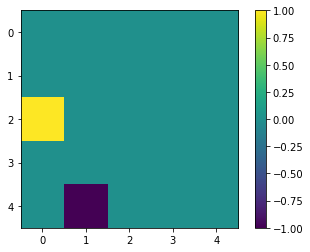

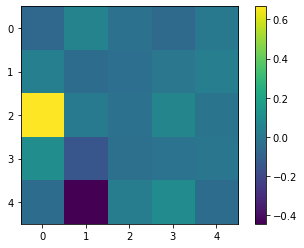

In [7]:
losses = []
for traj in test_data:
    for tensor in traj:
        model.eval()
        tensor = tensor.unsqueeze(0)
        decoded_tensor = model(tensor) 
        loss = F.mse_loss(torch.round(decoded_tensor), tensor)
        losses.append(loss.item())
print(pd.Series(losses).value_counts())
test_example= test_data[50][0].unsqueeze(0)
decoded_tensor = model(test_example)
image_all.view_tensor(test_example[0][0])
image_all.view_tensor(decoded_tensor[0][0].detach())

<h1>Similarity Scores

In [8]:
#Want, a similiratiy matrix. First, get similarity data.
latent_tensors, decoded_tensors, grid_tensors = image_all.get_fixed_goal_data(model,0)

In [9]:
len(latent_tensors), len(decoded_tensors), len(grid_tensors)

(25, 25, 25)

In [10]:
grid_tensors[0].shape, latent_tensors[0].shape, decoded_tensors[0].shape   

(torch.Size([5, 5]), torch.Size([1, 64]), torch.Size([1, 1, 5, 5]))

In [17]:
#Get cosine similarity matrix of how similar the grids are to each other. Should be 25x25 matrix
grid_similarity_matrix = []
latent_tensors_similarity_matrix = []
decoded_tensors_similarity_matrix = []
for i in range(len(grid_tensors)):
    grid_row = []
    latent_row = []
    decoded_row = []
    for j in range(len(grid_tensors)):
        grid_row.append(F.cosine_similarity(grid_tensors[i].flatten(), grid_tensors[j].flatten(), dim=0).item())
        latent_row.append(F.cosine_similarity(latent_tensors[i].flatten(), latent_tensors[j].flatten(), dim=0).item())
        decoded_row.append(F.cosine_similarity(decoded_tensors[i].flatten(), decoded_tensors[j].flatten(), dim=0).item())
    grid_similarity_matrix.append(grid_row)
    latent_tensors_similarity_matrix.append(latent_row)
    decoded_tensors_similarity_matrix.append(decoded_row)

grid_similarity_matrix = np.array(grid_similarity_matrix)
latent_tensors_similarity_matrix = np.array(latent_tensors_similarity_matrix)
decoded_tensors_similarity_matrix = np.array(decoded_tensors_similarity_matrix)



In [22]:
#Get MDS of each similarity matrix
mds_grid = MDS(n_components=2, dissimilarity='precomputed',normalized_stress='auto')
mds_grid.fit(grid_similarity_matrix)

mds_latent = MDS(n_components=2, dissimilarity='precomputed',normalized_stress='auto')
mds_latent.fit(latent_tensors_similarity_matrix)

mds_decoded = MDS(n_components=2, dissimilarity='precomputed',normalized_stress='auto')
mds_decoded.fit(decoded_tensors_similarity_matrix)

mds_grid_embedding = mds_grid.embedding_
mds_latent_embedding = mds_latent.embedding_
mds_decoded_embedding = mds_decoded.embedding_

In [23]:
grid_coordinates = [(i//5, i%5) for i in range(25)]
# Create an empty figure
fig = go.Figure()

# Add the MDS embeddings for the grid
fig.add_trace(go.Scatter(
    x=mds_grid_embedding[:, 0],
    y=mds_grid_embedding[:, 1],
    mode='markers+text',
    marker=dict(color='blue'),
    text=[f"({x},{y})" for i, (x, y) in enumerate(grid_coordinates)],
    name="Grid Embedding"
))

# Add the MDS embeddings for the latent space
fig.add_trace(go.Scatter(
    x=mds_latent_embedding[:, 0],
    y=mds_latent_embedding[:, 1],
    mode='markers+text',
    marker=dict(color='green'),
    #text=[f"({x},{y})" for i, (x, y) in enumerate(grid_coordinates)],
    name="Latent Embedding"
))

# Add the MDS embeddings for the decoded space
fig.add_trace(go.Scatter(
    x=mds_decoded_embedding[:, 0],
    y=mds_decoded_embedding[:, 1],
    mode='markers+text',
    marker=dict(color='red'),
    #text=[f"({x},{y})" for i, (x, y) in enumerate(grid_coordinates)],
    name="Decoded Embedding"
))

# Update the layout
fig.update_layout(
    title="MDS of Grid Similarity",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_traces(textposition='top center')

# Show the figure
fig.show()